## docs

https://clickhouse-driver.readthedocs.io/en/latest/index.html

In [4]:
# load connection script
%run ../../etc/rafal_load.py

uiConnect

In [5]:
url = wServer.value
print(url)

http://review_frugal-containers.the-ica.ninja:8080/


In [6]:
from datetime import datetime, timezone
import pytz
from clickhouse_driver import Client
import seaborn as sns
import matplotlib.pyplot as plt

sns.set(style="whitegrid")

tz= pytz.timezone('Europe/Paris')
tst= tz.localize(datetime.now())

In [7]:
def chk_to_dataframe(ckh_result):
    """Convert a clickhouse query result into Dataframe"""
    return pd.DataFrame.from_records(ckh_result[0], columns= [col for col, _ in ckh_result[1]])

def benchmarkQueries(client, queryDict, nb= 5, verbose= True):
    """compute perf stats on a dictionary of ClickHouse Queries
        queryDict: dict of name: query
            name = label name of the quey (any string)
            query = clickhouse query sent to the clickhouse driver
        nb: number of iteration to run the benchmark (default = 5)
        
        return: 
            tuple of (stats_dataframe, list_of_queries_result)
    """
    stats=[]
    
    for i in range(nb):
        dfs= []
        for name, query in queryDict.items():
            dfs.append(client.execute(query, with_column_types= True, settings= settings))
            dd= dict(qname=name, i=i, elapsed= client.last_query.elapsed, **client.last_query.profile_info.__dict__)
            if verbose:
                print(dd)
            else:
                print('.', end='')
            stats.append(dd)
    client.disconnect()
    return pd.DataFrame.from_records(stats), dfs

def plot_duration(stats, title= None, ax= None):
    """Draw a barplot to show average query duration"""
    nb= len(stats.i.unique())
    g = sns.barplot(x="qname", y="elapsed", data= stats, palette="muted", ax= ax)
    g.set_title(title + f'\n(median on {nb} iterations)')
    g.set_ylabel("duration in sec (avg)")
    g.set_xlabel("")
    sns.despine(left=True)
    return g

def getQueryStats(client_name= 'ClickHouse python-driver', os_user= None, fromDateTime= None, query= None, limit= 300):
    """ request query stats from table [distributed_query_log]
    """
    wTst = (f"and query_start_time >= '{fromDateTime.astimezone(timezone.utc).strftime('%Y-%m-%d %H:%M:%S')}'" 
            if fromDateTime else '')
    wOs = f"and os_user= '{os_user}'" if os_user else ''
    query_mon= f"""select `type`, `event_date`, `event_time`, `query_start_time`, `query_duration_ms`, `read_rows`, `read_bytes`, `written_rows`, `written_bytes`, 
        `result_rows`, `result_bytes`, `memory_usage`,`query`, `is_initial_query`,`user`, `query_id` ,
        `os_user`, `client_hostname`, `Settings.Names`, `Settings.Values`
    from distributed_query_log dql 
    where client_name = '{client_name}' {wOs} {wTst} and type != 'QueryStart'
    order by event_time desc limit {limit}"""
    res= client.execute(query_mon, with_column_types= True, settings= settings)
    df= chk_to_dataframe(res)
    if query:
        df= df[df['query'] == query]
    return df.reset_index()

In [8]:
host, port= url.replace('http://', '').split(':')
host, port

('review_frugal-containers.the-ica.ninja', '8080/')

In [9]:
settings = {'max_block_size': 100000}

In [10]:
client = Client(host= host, port= 9000, password= 'thisIsADevPassword', settings= settings)

In [11]:
client.execute('SHOW DATABASES')

[('default',), ('dict',), ('system',), ('tmp',)]

In [12]:
res= client.execute('SHOW CREATE TABLE mtms')
res

[("CREATE TABLE default.mtms (`Date` Date, `trade` UInt64, `csaId` UInt64, `nettingsetId` UInt64, `counterpartyId` UInt64, `scenario` UInt32, `mtms` Array(Float32), `commit` Int64, `factor` Int8) ENGINE = Distributed('{cluster}', '', shard_mtms, counterpartyId)",)]

## setup queries

In [13]:
where1= """((scenario GLOBAL IN 
    (
        SELECT DISTINCT scenario
        FROM default.diffusions
        WHERE ((diffusions[
        (
            SELECT indexOf(dates, toDate('2047-06-05'))
            FROM datearray
        )]) < 0.34) AND (SensId = 2)
    )) AND ((trade >= 0.) AND (trade <= 950.)) AND (toUInt64(csaId) IN 
    (
        SELECT csaId
        FROM dict.csaId
        WHERE csa IN ('BANK01')
    )) AND (Date IN ('2019-04-16'))) AND ((Date = '2019-04-16') AND (commit IN (1)))"""

In [14]:
where2= """((trade >= 0.) AND (trade <= 950.)) AND (commit IN (1))"""

In [15]:
query_ref = """
SELECT *
FROM (
SELECT    mtm, dates, scenario
FROM (
    SELECT    mtm, mtms_mtms_datearray_dates, scenario
    FROM
        (
        SELECT
            scenario, Date,
            {func}ForEach(arrayMap(x -> x * factor, mtms)) AS mtm
        FROM
            mtms
        WHERE {where}
        GROUP BY scenario, Date
        ) ARRAY JOIN mtm,
        arrayEnumerate(mtm) as mtms_mtms_datearray_dates ) ALL
INNER JOIN (
    SELECT
        dates,    mtms_mtms_datearray_dates
    FROM
        datearray ARRAY JOIN arrayEnumerate(dates) as mtms_mtms_datearray_dates,
        dates )
        USING mtms_mtms_datearray_dates
) WHERE {WhereArray}
"""

In [16]:
query_new= """
SELECT   {func}Merge(MtmsAggreg) AS mtm,   fdate,   scenario
FROM
(
   SELECT       MtmsAggregs,       dates AS fdates,       scenario
   FROM
   (
       SELECT           scenario,           Date,
           {func}StateForEach(arrayMap(x -> (x * factor), mtms)) AS MtmsAggregs
       FROM mtms
       WHERE {where}
       GROUP BY
           scenario,
           Date
   )
   INNER JOIN
   (
       SELECT dates, Date FROM datearraywithdate
   ) USING (Date)
)
ARRAY JOIN
   arrayResize(fdates, length(MtmsAggregs)) AS fdate,
   MtmsAggregs AS MtmsAggreg
WHERE {WhereArray}
GROUP BY
   fdate,
   scenario
"""

In [17]:
query_new1= """
SELECT   {func}Merge(MtmsAggreg) AS mtm,   fdate,   scenario
FROM
(
   SELECT       {func}MergeState(MtmsAggregs) as MtmsAggregs,       dates AS fdates,       scenario
   FROM
   (
       SELECT           scenario,           Date,
           {func}StateForEach(arrayMap(x -> (x * factor), mtms)) AS MtmsAggregs
       FROM mtms
       WHERE {where}
       GROUP BY
           scenario,
           Date
   )
   INNER JOIN
   (
       SELECT dates, Date FROM datearraywithdate
   ) USING (Date)
  Group by fdates, scenario
)
ARRAY JOIN
   arrayResize(fdates, length(MtmsAggregs)) AS fdate,
   MtmsAggregs AS MtmsAggreg
WHERE {WhereArray}
GROUP BY
   fdate,
   scenario

"""

In [25]:
query_new2= """
SELECT   sum(MtmsAggreg) AS mtm,   fdate,   scenario
FROM
(
   SELECT       MtmsAggregs,       dates AS fdates,       scenario
   FROM
   (
       SELECT           scenario,           Date,
           sumForEach(arrayMap(x -> (x * factor), mtms)) AS MtmsAggregs
       FROM mtms
       WHERE {where}
       GROUP BY
           scenario,
           Date
   )
   INNER JOIN
   (
       SELECT dates, Date FROM datearraywithdate
   ) USING (Date)
)
ARRAY JOIN
   arrayResize(fdates, length(MtmsAggregs)) AS fdate,
   MtmsAggregs AS MtmsAggreg
WHERE {WhereArray}
GROUP BY
   fdate,
   scenario
"""

In [38]:
# nb of iterations
nb= 5
# where clause
wheres= dict(narrow= where1, large= where2)
# metric function
funcs= ['sum', 'count', 'avg']

# where clause & nb of iterations
#filters= dict(narrow= (where1, 2), large= (where2, 2))
WhereArray= "1=1"

In [39]:
runs= [{'func': func,
        'where': where,
        'name': f"{func} agg\n{name} where",
        'queries': dict(query_ref= query_ref.format(where= where, func= func, WhereArray= WhereArray),
                        query_new= query_new.format(where= where, func= func, WhereArray= WhereArray),
                        query_new1= query_new.format(where= where, func= func, WhereArray= WhereArray),
                       ),
        'iterations': nb}
       for func in funcs for name, where in wheres.items()]
       #for name, (where, nb) in filters.items()]

for run in runs:
    if run['func'] == 'sum':
        run['queries']['query_sum']= query_new2.format(where= run['where'], WhereArray= WhereArray)
        #print(run['queries']['query_sum'])

In [40]:
stats0= {}
dfs= {}
g= {}

In [41]:
aggDict= dict(duration_sec_avg= ('elapsed', 'median'), 
              rows= ('rows', 'median'), 
              blocks= ('blocks', 'median'), 
              bytes= ('bytes', 'median'),
              nb= ('elapsed', 'count'),
             )

In [42]:
#for run, ax in zip(runs, axes):
for run in runs:
    name= run['name']
    print(f"\n--> Running serie '{name}' with {run['iterations']} iterations :")
    stats0[name], dfs[name]= benchmarkQueries(client, 
                                              queryDict= run['queries'], 
                                              nb= run['iterations'], 
                                              verbose= False)
    #g[name]= plot_duration(stats0[name], title= f"{name} filter", ax= ax)
    print('\n', f"{name} filter", 'with WHERE clause :\n', run['where'])

stats= pd.concat(stats0, names=['serie'])
stats


--> Running serie 'sum agg
narrow where' with 5 iterations :
....................
 sum agg
narrow where filter with WHERE clause :
 ((scenario GLOBAL IN 
    (
        SELECT DISTINCT scenario
        FROM default.diffusions
        WHERE ((diffusions[
        (
            SELECT indexOf(dates, toDate('2047-06-05'))
            FROM datearray
        )]) < 0.34) AND (SensId = 2)
    )) AND ((trade >= 0.) AND (trade <= 950.)) AND (toUInt64(csaId) IN 
    (
        SELECT csaId
        FROM dict.csaId
        WHERE csa IN ('BANK01')
    )) AND (Date IN ('2019-04-16'))) AND ((Date = '2019-04-16') AND (commit IN (1)))

--> Running serie 'sum agg
large where' with 5 iterations :
....................
 sum agg
large where filter with WHERE clause :
 ((trade >= 0.) AND (trade <= 950.)) AND (commit IN (1))

--> Running serie 'count agg
narrow where' with 5 iterations :
...............
 count agg
narrow where filter with WHERE clause :
 ((scenario GLOBAL IN 
    (
        SELECT DISTINCT scena

qname  i    elapsed    rows  blocks    bytes  \
serie                                                                         
sum agg\nnarrow where 0    query_ref  0   1.320867  295895       1  4142530   
                      1    query_new  0   1.377638  295895     256  4142530   
                      2   query_new1  0   1.551436  295895     256  4142530   
                      3    query_sum  0   1.522106  295895     256  4142530   
                      4    query_ref  1   1.721314  295895       1  4142530   
...                              ... ..        ...     ...     ...      ...   
avg agg\nlarge where  10   query_new  3  11.921872  322000     256  4508000   
                      11  query_new1  3  10.418368  322000     256  4508000   
                      12   query_ref  4  11.929150  632000     256  8848000   
                      13   query_new  4   9.039149  322000     256  4508000   
                      14  query_new1  4  10.830012  322000     256  4508000   

                          applied_limit  rows_before_limit  \
serie                                                        
sum agg\nnarrow where 0           False                  0   
                      1           False                  0   
                      2           False                  0   
                      3           False                  0   
                      4           False                  0   
...                                 ...                ...   
avg agg\nlarge where  10          False                  0   
                      11          False                  0   
                      12          False                  0   
                      13          False                  0   
                      14          False                  0   

                          calculated_rows_before_limit  
serie                                                   
sum agg\nnarrow where 0                           True  
                      1                           True  
                      2                           True  
                      3                           True  
                      4                           True  
...                                                ...  
avg agg\nlarge where  10                          True  
                      11                          True  
                      12                          True  
                      13                          True  
                      14                          True  

[100 rows x 9 columns]

## Distributed query log

In [43]:
client_name= 'ClickHouse python-driver'
client_hostname= 'LAPTOP-M7C54VOV'
os_user= 'chdec'

In [44]:
%%time
# request query stats from table [distributed_query_log], filtered by previous queries
dropFields= ['query', 'is_initial_query', 'client_hostname', 'query_start_time']
distQueryLog= pd.concat({run['name']: pd.concat({name: getQueryStats(fromDateTime= tst, query= query) 
                                                 for name, query in run['queries'].items()}, 
                                                names= ['qname']) 
                         for run in runs}, names= ['serie']
                     ).drop(dropFields, axis= 1)
distQueryLog.index.names = ['serie', 'qname', 'i']

# concat results with clickHouse client stats
ckhqStats= pd.concat([stats.reset_index(level=1, drop= True).set_index(['qname', 'i'], append= True), 
                      distQueryLog], axis= 1
                    ).assign(query_duration_sec= lambda x: x.query_duration_ms/1000)

ckhqStats.head()

Wall time: 2.01 s


elapsed      rows  blocks      bytes  \
serie                qname     i                                           
avg agg\nlarge where query_new 0   9.842734  322000.0   256.0  4508000.0   
                               1   9.774114  322000.0   256.0  4508000.0   
                               2  16.370936  322000.0   256.0  4508000.0   
                               3  11.921872  322000.0   256.0  4508000.0   
                               4   9.039149  322000.0   256.0  4508000.0   

                                 applied_limit  rows_before_limit  \
serie                qname     i                                    
avg agg\nlarge where query_new 0         False                0.0   
                               1         False                0.0   
                               2         False                0.0   
                               3         False                0.0   
                               4         False                0.0   

                                 calculated_rows_before_limit  index  \
serie                qname     i                                       
avg agg\nlarge where query_new 0                         True    1.0   
                               1                         True    6.0   
                               2                         True   10.0   
                               3                         True   16.0   
                               4                         True   19.0   

                                         type  event_date  ... written_bytes  \
serie                qname     i                           ...                 
avg agg\nlarge where query_new 0  QueryFinish  2020-06-23  ...           0.0   
                               1  QueryFinish  2020-06-23  ...           0.0   
                               2  QueryFinish  2020-06-23  ...           0.0   
                               3  QueryFinish  2020-06-23  ...           0.0   
                               4  QueryFinish  2020-06-23  ...           0.0   

                                  result_rows  result_bytes  memory_usage  \
serie                qname     i                                            
avg agg\nlarge where query_new 0     322000.0     4508000.0    38003322.0   
                               1     322000.0     4508000.0    33761704.0   
                               2     322000.0     4508000.0    38003482.0   
                               3     322000.0     4508000.0    33761704.0   
                               4     322000.0     4508000.0    38003322.0   

                                     user  \
serie                qname     i            
avg agg\nlarge where query_new 0  default   
                               1  default   
                               2  default   
                               3  default   
                               4  default   

                                                              query_id  \
serie                qname     i                                         
avg agg\nlarge where query_new 0  be43262d-4d2d-4005-b87e-c77859de6820   
                               1  71696511-daa3-4964-b587-b997539aab3c   
                               2  63a1688b-d241-4deb-be13-6da00f5f6553   
                               3  d11104cb-cf21-41bc-baef-9d82d8116fa1   
                               4  90b8799c-37c4-4e2b-b538-fa31aafe335a   

                                           os_user  \
serie                qname     i                     
avg agg\nlarge where query_new 0  CharlesDeCourcel   
                               1  CharlesDeCourcel   
                               2  CharlesDeCourcel   
                               3  CharlesDeCourcel   
                               4  CharlesDeCourcel   

                                                                     Settings.Names  \
serie                qname     i                                                      
avg agg\nlarge where quer

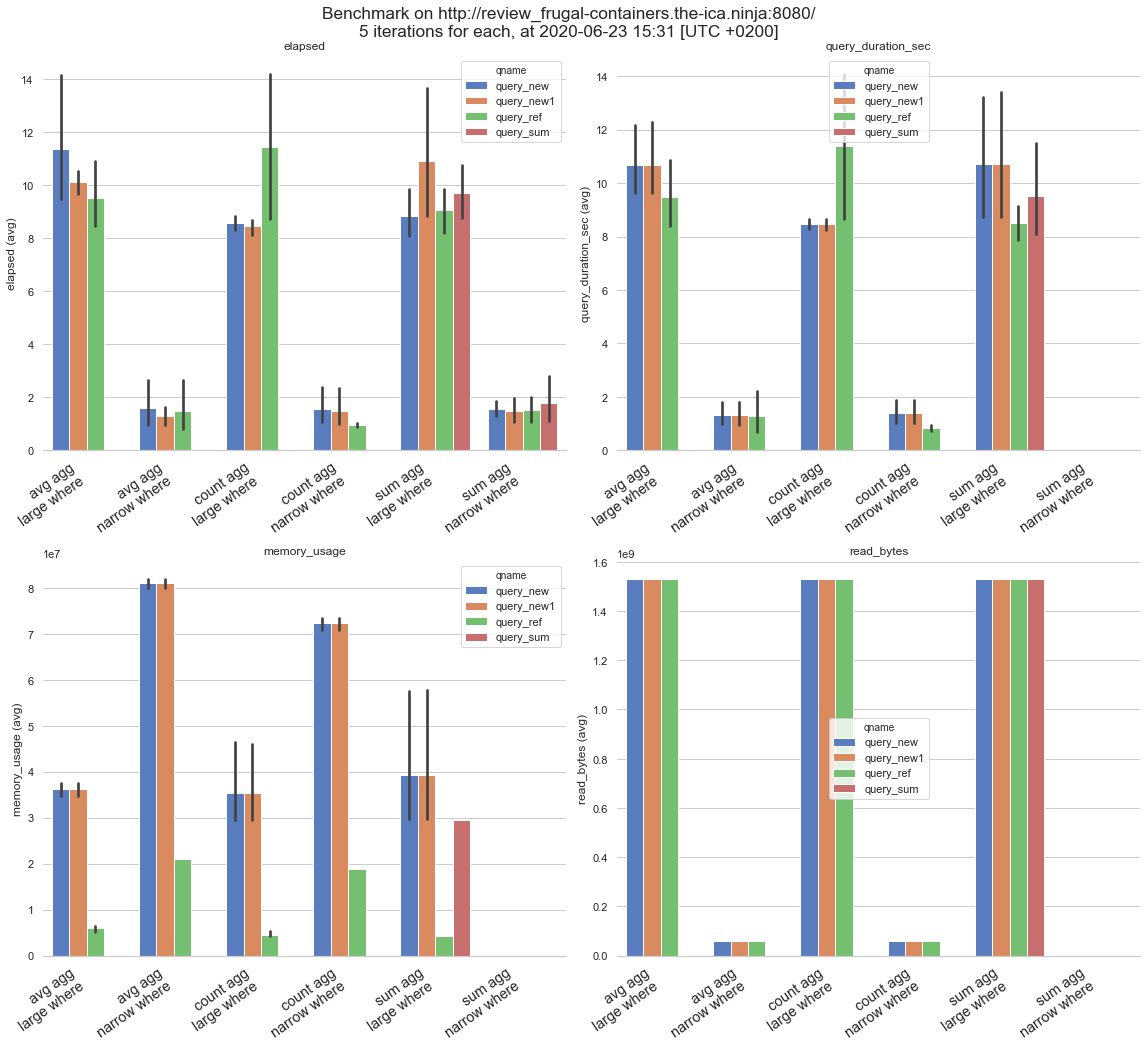

In [45]:
# plot a seaborn bar graph, with average stats
fig1, axes = plt.subplots(2,2)
fig1.set_size_inches(16, 14)
data= ckhqStats.reset_index()
flds= ["elapsed", "query_duration_sec", "memory_usage", "read_bytes"]
for field, ax in zip(flds, axes.flatten()):
    g = sns.barplot(x="serie", y= field, hue= "qname",data= data, palette="muted", ax= ax)
    g.set_title(field)
    g.set_ylabel(f"{field} (avg)")
    g.set_xlabel("")
    g.set_xticklabels(g.get_xticklabels(), 
                      rotation= 35, 
                      horizontalalignment='right',
                      fontweight='light',
                      fontsize='large')

plt.suptitle(f"Benchmark on {url}\n{nb} iterations for each, {tst:at %Y-%m-%d %H:%M [UTC %z]}", 
             fontsize= 'x-large', y=1.03)
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
sns.despine(left=True)

In [46]:
aggDict2= dict(elapsed= 'median', query_duration_sec= 'median', read_bytes= 'median', result_rows='median',
               memory_usage= 'median', event_time= 'first', query_id= 'first')
queryReport= ckhqStats.groupby(['serie', 'qname']
                                 ).agg(aggDict2).unstack(0)
delta = queryReport._get_numeric_data().apply(lambda df: df.loc['query_new'] / df.loc['query_ref'] -1)
fmt_cols= {col: "{:,}"  for col, typ in queryReport.dtypes.iteritems() if typ == 'int64'}
fmt_cols.update({('memory_usage', 'large'): "{:,.0f}", ('memory_usage', 'narrow'): "{:,.0f}"})
queryReport.style.format(fmt_cols)

### Cache effet ?

In [47]:
# % increase of first query duration compared to median duration
cacheEffect= ckhqStats.xs(0, level='i').query_duration_sec - ckhqStats.groupby(level=[0,1]).query_duration_sec.median()
cacheEffect

serie                    qname     
avg agg\nlarge where     query_new    -0.8530
                         query_new1   -0.8530
                         query_ref     3.3100
avg agg\nnarrow where    query_new     0.3915
                         query_new1    0.3915
                         query_ref     2.5100
count agg\nlarge where   query_new     0.0305
                         query_new1    0.0305
                         query_ref     5.9090
count agg\nnarrow where  query_new     1.6810
                         query_new1    1.6810
                         query_ref     0.0000
sum agg\nlarge where     query_new    -0.5695
                         query_new1   -0.5695
                         query_ref     0.6425
                         query_sum    -0.8220
sum agg\nnarrow where    query_new        NaN
                         query_new1       NaN
                         query_ref        NaN
                         query_sum        NaN
Name: query_duration_sec, dtype: float64

In [48]:
# max cache value in sec
cacheEffect.index[cacheEffect.argmax()], cacheEffect.iloc[cacheEffect.argmax()]

(('count agg\nlarge where', 'query_ref'), 5.908999999999999)

In [49]:
ckhqStats.loc[('sum agg\nnarrow where')].query_duration_sec#('query_ref', level='qname')

qname       i
query_new   0   NaN
            1   NaN
            2   NaN
            3   NaN
            4   NaN
query_new1  0   NaN
            1   NaN
            2   NaN
            3   NaN
            4   NaN
query_ref   0   NaN
            1   NaN
            2   NaN
            3   NaN
            4   NaN
query_sum   0   NaN
            1   NaN
            2   NaN
            3   NaN
            4   NaN
Name: query_duration_sec, dtype: float64